In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from notebooks.mnist_classifier.mnist_tiny_cnn import TinyCNN

from mixer.mixer import SetMixer
from datasets.mnist import MNISTDataset

from torch.utils.data import DataLoader
from itertools import product

from sklearn.decomposition import PCA

from tqdm.notebook import tqdm


In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'mnist_multinomial' in c['name'] 
                    and c['encoder']=='ConvDistributionEncoder']
cfg = cfg[0]

In [3]:
# load model and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

In [4]:
N = 1200  # must be divisible by 3
blk = N // 3

# build base row pattern
row = torch.cat([torch.zeros(blk), torch.ones(blk), torch.zeros(blk)])
mix_probs = torch.stack([row]*N)

In [5]:
dataset = MNISTDataset(n_classes=3, n_sets=N, set_size=5000)
encoder, generator = load_model(cfg['config'], cfg['dir'], 'cuda')

In [6]:
loss_records = []
all_z = []
all_ss = []

with torch.no_grad():
    for ss in tqdm(np.logspace(1, 4, 4, dtype=int)):
        mixer = SetMixer(k=3, mixed_set_size=ss, n_mixed_sets=N)
        mixed_sets = mixer.prescribed_mixing(dataset.data.flatten(start_dim=2), mix_probs)
        mixed_sets = mixed_sets.to(torch.float).reshape(-1, ss, 1, 28, 28)
        dataset.data = mixed_sets
        loader = DataLoader(dataset, batch_size=1, shuffle=False)

        for batch in loader:
            x = batch['samples'].to('cuda')
            z = encoder(x)

            loss = generator.loss(x.view(-1, *x.shape[2:]), z)

            loss_records.append({'loss': loss.item(), 'ss': ss})
            all_z.append(z.squeeze().cpu())
            all_ss.append(ss)

# combine z + ss
z_all = torch.stack(all_z).numpy()
ss_all = np.array(all_ss)

# pca fit on all z
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_all)

# dataframe for plotting
vis_df = pd.DataFrame({'PC1': z_pca[:, 0], 'PC2': z_pca[:, 1], 'ss': ss_all})
loss_df = pd.DataFrame(loss_records)


  0%|          | 0/4 [00:00<?, ?it/s]

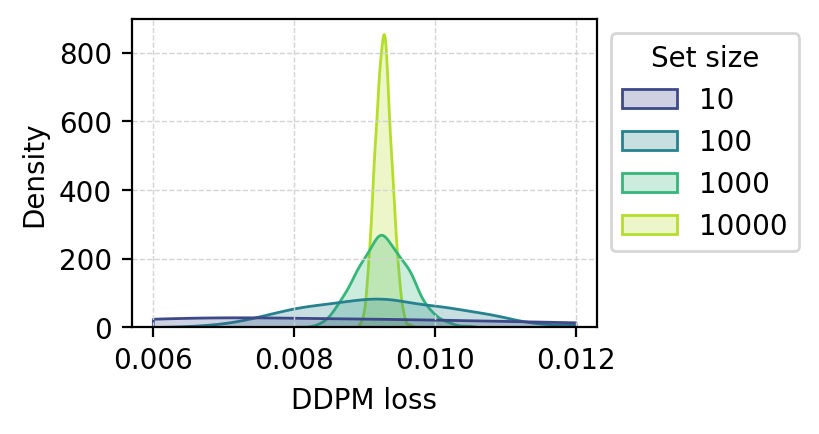

In [34]:
fig = plt.figure(figsize=(3,2), dpi=200)
plt.grid(True, color='lightgrey', 
         linestyle='--', linewidth=0.5, zorder=0)
loss_df['Set size'] = loss_df['ss']
loss_df['DDPM loss'] = loss_df['loss']
g = sns.kdeplot(loss_df, x='DDPM loss', hue='Set size',
             palette=sns.color_palette('viridis', 8)[1::2], 
             fill=True, log_scale=False, clip=(0.006, 0.012))
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

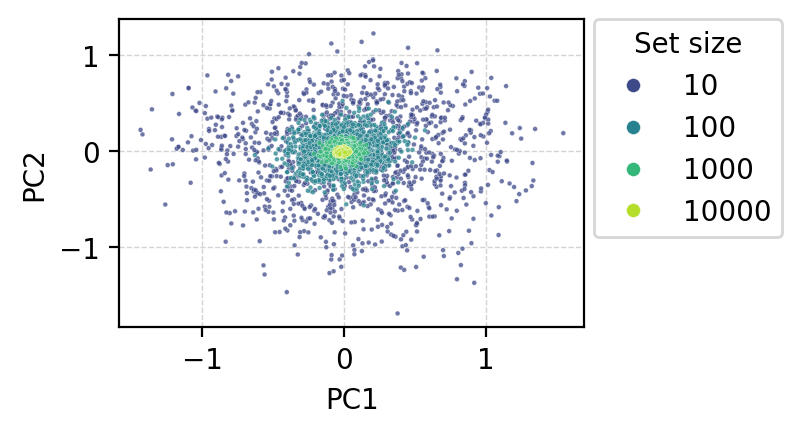

In [35]:
# plot!
plt.figure(figsize=(3, 2), dpi=200)
plt.grid(True, color='lightgrey', 
         linestyle='--', linewidth=0.5, zorder=0)
g = sns.scatterplot(data=vis_df, x='PC1', y='PC2', 
                hue='ss', 
                palette=sns.color_palette('viridis', 8)[1::2], 
                s=3, alpha=0.75, zorder=10)
g.legend_.set_title("Set size")

handles, lables = g.get_legend_handles_labels()
for h in handles:
    h.set_markersize(5)
    h.set_alpha(1)



# replace legend using handles and labels from above
lgnd = plt.legend(handles, lables, bbox_to_anchor=(1.02, 1), loc='upper left',
                   borderaxespad=0, title='Set size')

In [9]:
mix_probs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])